In [1]:
# Imports et configurations d'affichage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings("ignore")

import nltk

# Analyse descriptive préliminaire

## Classes

On peut effectuer une analyse descriptive univariée des classements donnés par des opérateurs. Cette analyse permet d'étudier la distribution des classes, ce qui permettrait de relever des problèmes de sur/sous représentation.

In [2]:
classes = pd.read_csv('./input/Tobacco3482.csv', sep = ",")
classes.sample(5)

,img_path,label
2249,Memo/2074163081.jpg,Memo
1708,Letter/520693484+-3486.jpg,Letter
2098,Memo/2047523173_3191.jpg,Memo
2342,Memo/87293861_3880.jpg,Memo
2537,News/2025880123.jpg,News


### Données manquantes et mal classées

On peut ensuite vérifier s'il y a des étiquettes manquantes ou bien des incohérence entre le classement et le dossier où est localisée l'instance.

In [4]:
print("Pourcentage d'étiquettes manquantes :", 1.0 - classes.shape[0] / classes.dropna().shape[0])
print("Etiquettes :", classes.label.unique())
s = 0
for i in range(classes.shape[0]):
    s += classes["img_path"][i].split("/")[0] == classes["label"][i]
print("Misclassified :", classes.shape[0] - s)
classes.describe()

Pourcentage d'étiquettes manquantes : 0.0
Etiquettes : ['Advertisement' 'Email' 'Form' 'Letter' 'Memo' 'News' 'Note' 'Report'
 'Resume' 'Scientific']
Misclassified : 0


,img_path,label
count,3482,3482
unique,3482,10
top,Memo/2054641494.jpg,Memo
freq,1,620


### Distribution des étiquettes

Maintenant qu'on sait qu'il n'y a pas d'étiquettes manquantes ni mal placées, on peut observer la distribution des étiquettes.

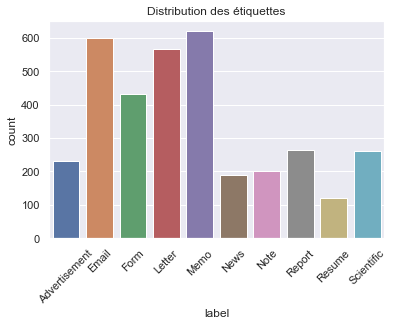

In [5]:
classes_lab = LabelEncoder()
labels = classes_lab.fit_transform(classes.label)
cp = sns.countplot(classes.label)
cp.set_title("Distribution des étiquettes")
_ = cp.set_xticklabels(rotation = 45, labels = classes.label.unique())

On constate qu'il y a quatre étiquettes qui sont plus présentes que les autres, mais on ne peut pas parler de sur/sous-représentation. Cependant, en vue du faible nombre de données, et en tenant compte qu'on effectuera une tâche de traitement automatique du langage naturel, on pourrait envisager de mettre en place des techniques de génération/augmentation de données.

## Classification Naïve Bayésienne Multinomiale

Suite à l'analyse descriptive préliminaire, on peut appliquer un premier algorithme "simple" : un classifieur bayésien naïf. Le principe de ce classifieur est d'utiliser une hypothèse d'indépendence entre les caractéristiques des classes pour estimer une probabilité associée à l'appartenance à une classe.

In [36]:
# On récupère les données textuelles obtenues par OCR.
data = []
ocr_path = classes.img_path.replace(to_replace=".jpg", value = ".txt", regex = True)
for path in ocr_path:
    with open('./input/Tobacco3482-OCR/' + path, encoding = "utf8") as f:
        data.append(f.read())

In [80]:
# On prépare un premier jeu de données d'apprentissage, validation et test.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

x_train, x_test, y_train, y_test = train_test_split(data, classes.label, test_size = 0.2, random_state = 30996)
x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 30996)

In [85]:
# On produit une matrice de termes-documents
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
x_train_counts = vectorizer.transform(x_train)
x_test_counts = vectorizer.transform(x_test)

# Et on calcule le tfidf (term frequency-inverse document frequency)
tf_transformer = TfidfTransformer().fit(x_train_counts)
x_train_tf = tf_transformer.transform(x_train_counts)
x_test_tf = tf_transformer.transform(x_test_counts)

In [86]:
# Entraînement du modèle
model = MultinomialNB()
model.fit(x_train_tf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [87]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Affichage du rapport de classification et de la matrice de confusion
print(classification_report(y_test, model.predict(x_test_tf)))
confusion_matrix(y_train, model.predict(x_train_tf))

               precision    recall  f1-score   support

Advertisement       1.00      0.05      0.09        21
        Email       0.91      0.88      0.89        58
         Form       0.60      0.46      0.52        39
       Letter       0.33      0.83      0.47        52
         Memo       0.42      0.85      0.56        65
         News       0.00      0.00      0.00        28
         Note       0.00      0.00      0.00        25
       Report       0.00      0.00      0.00        23
       Resume       1.00      0.07      0.13        14
   Scientific       0.00      0.00      0.00        24

  avg / total       0.45      0.48      0.39       349



array([[ 56,   2,  11,  47,  68,   0,   0,   0,   0,   0],
       [  0, 457,   0,  11,  12,   0,   0,   0,   0,   0],
       [  0,   3, 234,  20,  81,   0,   0,   0,   0,   0],
       [  0,   1,   0, 426,  27,   0,   0,   0,   0,   0],
       [  0,   0,   0,   8, 489,   0,   0,   0,   0,   0],
       [  0,   2,   5, 105,  19,  12,   0,   0,   0,   0],
       [  0,  19,  22,  26,  93,   0,   1,   0,   0,   0],
       [  0,   1,   1, 116,  94,   0,   0,   0,   0,   0],
       [  0,   0,   0,  55,   0,   0,   0,   0,  43,   0],
       [  0,   1,  13,  79,  85,   0,   0,   0,   0,  40]], dtype=int64)

Les résultats ne sont pas très corrects. D'une part, les métriques usuelles de classification (Precision, Recall, F1-score) indiquent des problèmes surtout pour les classes _News, Note, Report_ et _Scientific_. D'autre part, la matrice de confusion permet de voir les classifications faites par le modèle. On observe que le faible nombre d'exemples pour certaines classes a un réel impact pour cette séparation des données et que le modèle n'arrive pas vraiment à caractériser certaines classes. Les scores de 0.0 pour la classe _Scientific_ ne sont pas très cohérents entre l'entraînement et le test, ce qui pourrait indiquer de l'overfitting.

Après un premier run du pipeline _vectorization -> tf-idf -> classification_, on peut effectuer une recherche manuelle exhaustive avec validation croisée (GridSearch Cross-Validation) dans le but de trouver un ensemble de paramètres maximisant l'adéquation du modèle.

Pour la vectorization, on a deux paramètres : _max_\__df_ et _max_\__features_. Le premier hyperparamètre correspond à un seuil maximal d'occurrence pour les termes, i.e. on ne prend pas en compte les termes qui sont trop fréquents (similaire à la notion de stop words). Le deuxième hyperparamètre correspond au nombre maximal de termes dans la matrice, e.g. si _max_\__features_ vaut 10, on tient compte que des 10 termes les plus fréquents dans le corpus.

Pour la classification, on a un paramètre : _alpha_. Ce paramètre correspond à un coefficient additif de lissage.

In [78]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time
import logging
# Affichage du log pendant l'exécution
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# Définition du pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

# Valeurs des paramètres à tester
parameters = {
    'vect__max_df': (0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
    'vect__max_features' : (500, 1000, 1500, 2000),
    'clf__alpha': (0.01, 0.02, 0.05, 0.1, 0.2,0.5, 1.0)
}

# Recherche par validation croisée des meilleurs paramètres pour l'extraction et la classification
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(x_dev, y_dev)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (0.01,
                0.02,
                0.03,
                0.04,
                0.05,
                0.1,
                0.2,
                0.3,
                0.4,
                0.5,
                0.6,
                0.7,
                0.8,
                0.9,
                1.0),
 'vect__max_df': (0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0),
 'vect__max_features': (500, 1000, 1500, 2000)}
Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.5min finished


done in 88.511s

Best score: 0.711
Best parameters set:
	clf__alpha: 0.05
	vect__max_df: 0.7
	vect__max_features: 1000


Le meilleur triplet de paramètres est (_max_\__features_ = 1000, _max_\__df_ = 0.7, _alpha_ = 0.05). Le meilleur score est assez bon. On passe au rapport et à la matrice de confusion pour mieux comprendre ce modèle.

In [84]:
best_estimator = grid_search.best_estimator_

# Affichage du rapport de classification et de la matrice de confusion
print(classification_report(y_test, best_estimator.predict(x_test)))
confusion_matrix(y_train, best_estimator.predict(x_train))

               precision    recall  f1-score   support

Advertisement       0.57      0.57      0.57        21
        Email       0.82      0.95      0.88        58
         Form       0.82      0.82      0.82        39
       Letter       0.74      0.75      0.74        52
         Memo       0.61      0.77      0.68        65
         News       0.75      0.86      0.80        28
         Note       1.00      0.12      0.21        25
       Report       0.43      0.52      0.47        23
       Resume       1.00      1.00      1.00        14
   Scientific       1.00      0.42      0.59        24

  avg / total       0.75      0.72      0.70       349



array([[110,  18,  19,   8,  10,  16,   1,   1,   0,   1],
       [  0, 444,   2,   9,  21,   3,   0,   1,   0,   0],
       [ 10,   6, 253,  11,  37,   6,   4,   5,   0,   6],
       [  2,   5,   5, 314,  79,  14,   0,  33,   0,   2],
       [  0,   9,  14,  50, 401,   6,   0,  13,   0,   4],
       [  4,   2,   6,   3,   3, 120,   0,   3,   0,   2],
       [ 19,  58,  42,  14,  13,   4,   8,   1,   0,   2],
       [  2,   1,   5,  43,  42,  20,   1,  88,   0,  10],
       [  0,   0,   0,   0,   0,   0,   0,   0,  98,   0],
       [  4,   2,  26,  15,  23,   5,   1,  30,   1, 111]], dtype=int64)

On voit que le modèle avec les _meilleurs_ hyperparamètres (parmi ceux qu'on a considérés) réussi beaucoup mieux que le modèle de base.